## General Settings

In [1]:
# For loading, manipulating and visualising data in tables
import pandas as pd
# For Operating System commands
import os
# For high-level file operations
import shutil
# For doing math
import numpy as np
# For making plots and graphical visualisations
import matplotlib.pyplot as plt
# For fancy (but slow) plotting
import seaborn as sns
# For progress bar
from tqdm import tqdm

# models
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor

## User Settings

In [2]:
# Local path to (copied and/or cleaned) *.parquet files
strPqtLocPath = 'local_parquet_clean'
# Local path to *.csv files
strLocPath = 'local_files'

bTrainGlobalModel = False
bTrainModel = True
bSaveModel = True

# Read data

## Challenge set & features

In [3]:
df_c = pd.read_csv(os.path.join(strLocPath,"challenge_set.csv"))

#df_feat_c = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410050054.csv")) # 'ROC_FL100to200' only
#df_feat_c = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410122340.csv")) # 'ROC_FL100to200' and 'TAS_FL100to200'
#df_feat_c = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410170106.csv")) # 'ROC_FL100to200', 'TAS_FL100to200' and 'Temp_FL100to200'
#df_feat_c = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410201238.csv")) # more physical features
#df_feat_c = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410250135.csv")) # more physical features also for FL50 to FL100
#df_feat_c = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410260207.csv")) # more physical features also for FL50 to FL100, partly fixed track feature
df_feat_c = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410271319.csv")) # more physical features also for FL50 to FL100, fixed track feature

df_c = pd.merge(df_c, df_feat_c, on='flight_id', how='left')

df_c['cset'] = True
print(df_c) 

        flight_id        date                          callsign  adep  \
0       248763780  2022-01-01  3840d84f25d3f5fcc0a1be3076bb4039  EGLL   
1       248760618  2022-01-01  f6f610e73002b8892a239a81321f7f1d  LEBL   
2       248753824  2022-01-01  139670936660762c230ca92556ba842b  ESSA   
3       248753852  2022-01-01  509dc61bb54fbab0e5406067c95603e2  LSZH   
4       248755934  2022-01-01  d0610d000dcf26b1d7bba8103ecc393d  EIDW   
...           ...         ...                               ...   ...   
369008  258058361  2022-12-31  85ee68e5b7b5acf24ba00d1318eca1e8  LFPG   
369009  258071247  2022-12-31  570cf7d5ebbd691bcba63e7466607da7  LTFM   
369010  258059152  2022-12-31  5a7e43e4f981539ae3d3b1cb31591b7c  EDDL   
369011  258072276  2022-12-31  a1c078516f9f9e90cacec61854cad45b  LFPG   
369012  258069969  2022-12-31  6c98fcaa191dec632b87b46511f1d2da  LEMD   

                      name_adep country_code_adep  ades           name_ades  \
0               London Heathrow             

In [4]:
# Rate of descent
df_rod_c = pd.read_csv(os.path.join(strLocPath,"df_all_feat_DE_202410271004.csv")) # RoD
df_c = pd.merge(df_c, df_rod_c, on='flight_id', how='left', suffixes=(None, '_DE'))
df_c

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,Q_FL300,Q_FL200_DE,Q_mFL300to200,TAS_FL300,TAS_FL200_DE,TAS_mFL300to200,dHp_FL300,dHp_FL200_DE,dHp_mFL300to200,cs_d_track_300to200
0,248763780,2022-01-01,3840d84f25d3f5fcc0a1be3076bb4039,EGLL,London Heathrow,GB,EICK,Cork,IE,2022-01-01T13:46:00Z,...,-178.09,-171.30,-151.78,442.71,422.52,438.38,-18.29,-15.24,-12.32,2.12
1,248760618,2022-01-01,f6f610e73002b8892a239a81321f7f1d,LEBL,Barcelona,ES,KMIA,Miami,US,2022-01-01T09:55:00Z,...,-16.30,-15.50,-15.88,422.83,354.56,388.42,-1.31,-1.31,-1.31,5.82
2,248753824,2022-01-01,139670936660762c230ca92556ba842b,ESSA,Stockholm Arlanda,SE,KORD,Chicago O'Hare,US,2022-01-01T09:39:00Z,...,-68.75,-75.77,-58.35,435.48,370.74,385.34,-5.08,-6.10,-5.08,2.34
3,248753852,2022-01-01,509dc61bb54fbab0e5406067c95603e2,LSZH,Zurich,CH,KPHL,Philadelphia,US,2022-01-01T11:04:00Z,...,-2.31,-1.15,-67.86,474.49,423.13,442.35,-0.25,0.00,-5.97,2.56
4,248755934,2022-01-01,d0610d000dcf26b1d7bba8103ecc393d,EIDW,Dublin,IE,EGLL,London Heathrow,GB,2022-01-01T12:36:00Z,...,-111.25,-128.64,-135.68,422.56,371.00,392.55,-12.19,-10.67,-10.92,1.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369008,258058361,2022-12-31,85ee68e5b7b5acf24ba00d1318eca1e8,LFPG,Paris Charles de Gaulle,FR,KMIA,Miami,US,2022-12-31T09:38:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369009,258071247,2022-12-31,570cf7d5ebbd691bcba63e7466607da7,LTFM,iGA Istanbul,TR,EDDB,Berlin Brandenburg,DE,2022-12-31T09:27:00Z,...,-121.95,-108.71,-121.95,413.37,362.27,398.59,-11.18,-9.40,-10.67,1.05
369010,258059152,2022-12-31,5a7e43e4f981539ae3d3b1cb31591b7c,EDDL,Dusseldorf,DE,EIDW,Dublin,IE,2022-12-31T09:52:00Z,...,-169.26,-138.60,-148.30,409.79,390.10,409.79,-13.21,-11.94,-12.32,9.48
369011,258072276,2022-12-31,a1c078516f9f9e90cacec61854cad45b,LFPG,Paris Charles de Gaulle,FR,EIDW,Dublin,IE,2022-12-31T09:37:00Z,...,-168.61,-84.28,-170.88,423.20,376.13,391.94,-18.80,-6.35,-15.11,16.93


## Submission set & features

In [5]:
# Initial submission set
#df_s = pd.read_csv(os.path.join(strLocPath,"submission_set.csv"))
#df_feat_s = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410112052.csv")) # 'ROC_FL100to200' only
#df_feat_s = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410130034.csv")) # 'ROC_FL100to200' and 'TAS_FL100to200'
#df_feat_s = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410171048.csv")) # 'ROC_FL100to200', 'TAS_FL100to200' and 'Temp_FL100to200'
#df_feat_s = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410181151.csv")) # 'ROC_FL100to200', 'TAS_FL100to200' and 'Temp_FL100to200'

# Final submission set
df_s = pd.read_csv(os.path.join(strLocPath,"final_submission_set.csv"))
#df_feat_s = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410201901.csv")) # more physical features
#df_feat_s = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410250556.csv")) # more physical features also for FL50 to FL100
#df_feat_s = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410252241.csv")) # more physical features also for FL50 to FL100, partly fixed track feature
df_feat_s = pd.read_csv(os.path.join(strLocPath,"df_all_feat_202410271437.csv")) # more physical features also for FL50 to FL100, fixed track feature


df_s = pd.merge(df_s, df_feat_s, on='flight_id', how='left')

df_s['cset'] = False
print(df_s) 

        flight_id        date                          callsign  adep  \
0       248753821  2022-01-01  3b3de0f3ad0ee192513995c02f7bf7cf  LTFJ   
1       248753822  2022-01-01  e06dd03d4a879ca37d9e18c1bd7cad16  EBBR   
2       248754498  2022-01-01  2d3b1c962c78c4ebeef11bcd51b9e94c  KMIA   
3       248763650  2022-01-01  35f7721f68bf85128195547ae38b0f04  EBBR   
4       248763651  2022-01-01  eb56918bee9bc5204624186b9bcc4391  LSZH   
...           ...         ...                               ...   ...   
158144  258068876  2022-12-31  c9fca302ca2e28acab0eb0bb1b46f11b  LTFM   
158145  258064675  2022-12-31  00f96ad0e382476649574ba044c764fc  EHAM   
158146  258065436  2022-12-31  87c552b7f6d9bbd16a66e95df761c7f2  LEBL   
158147  258058138  2022-12-31  2cd57e434494606c965bac87c024bda2  LIPE   
158148  258058370  2022-12-31  5f0c222c7f7ceff3fbe75c854cce74c9  UBBB   

                     name_adep country_code_adep  ades  \
0       Istanbul Sabiha Gokcen                TR  LFLL   
1      

In [6]:
# Rate of descent
df_rod_s = pd.read_csv(os.path.join(strLocPath,"df_all_feat_DE_202410271653.csv")) # RoD
df_s = pd.merge(df_s, df_rod_s, on='flight_id', how='left', suffixes=(None, '_DE'))
df_s

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,Q_FL300,Q_FL200_DE,Q_mFL300to200,TAS_FL300,TAS_FL200_DE,TAS_mFL300to200,dHp_FL300,dHp_FL200_DE,dHp_mFL300to200,cs_d_track_300to200
0,248753821,2022-01-01,3b3de0f3ad0ee192513995c02f7bf7cf,LTFJ,Istanbul Sabiha Gokcen,TR,LFLL,Lyon,FR,2022-01-01T09:44:00Z,...,-66.02,-37.63,-68.50,433.70,375.39,415.10,-5.08,-2.79,-5.59,12.06
1,248753822,2022-01-01,e06dd03d4a879ca37d9e18c1bd7cad16,EBBR,Brussels,BE,KJFK,New York JFK,US,2022-01-01T09:45:00Z,...,-102.16,-96.99,-107.34,443.82,403.77,436.98,-10.16,-8.13,-10.03,21.85
2,248754498,2022-01-01,2d3b1c962c78c4ebeef11bcd51b9e94c,KMIA,Miami,US,EGLL,London Heathrow,GB,2022-01-01T01:52:00Z,...,-109.52,-98.79,-111.86,429.13,375.98,406.60,-9.40,-8.89,-9.27,26.96
3,248763650,2022-01-01,35f7721f68bf85128195547ae38b0f04,EBBR,Brussels,BE,LEAL,Alicante,ES,2022-01-01T12:02:00Z,...,-57.03,-133.19,-51.08,413.39,404.29,410.55,-4.83,-12.45,-4.19,3.23
4,248763651,2022-01-01,eb56918bee9bc5204624186b9bcc4391,LSZH,Zurich,CH,LFPG,Paris Charles de Gaulle,FR,2022-01-01T12:03:00Z,...,-87.38,-64.56,-103.06,416.36,371.33,404.85,-10.67,-3.81,-9.14,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158144,258068876,2022-12-31,c9fca302ca2e28acab0eb0bb1b46f11b,LTFM,iGA Istanbul,TR,LSZH,Zurich,CH,2022-12-31T09:25:00Z,...,-232.50,-113.85,-113.85,423.42,390.93,408.61,-21.08,-10.16,-10.16,11.09
158145,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158146,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158147,258058138,2022-12-31,2cd57e434494606c965bac87c024bda2,LIPE,Bologna,IT,LOWW,Vienna,AT,2022-12-31T09:37:00Z,...,-135.91,-91.66,-110.65,415.72,369.16,396.69,-10.92,-7.87,-10.54,12.96


In [7]:
df_s.columns

Index(['flight_id', 'date', 'callsign', 'adep', 'name_adep',
       'country_code_adep', 'ades', 'name_ades', 'country_code_ades',
       'actual_offblock_time', 'arrival_time', 'aircraft_type', 'wtc',
       'airline', 'flight_duration', 'taxiout_time', 'flown_distance', 'tow',
       'CL_FL50_start', 'CL_FL50_alt', 'CL_FL100_start', 'CL_FL100_alt',
       'ROC_FL50to100', 'TAS_FL50to100', 'Temp_FL50to100', 'Q_FL50',
       'Q_FL100a', 'Q_mFL50to100', 'TAS_FL50', 'TAS_FL100a', 'TAS_mFL50to100',
       'dHp_FL50', 'dHp_FL100a', 'dHp_mFL50to100', 'cs_d_track_50to100',
       'CL_FL200_start', 'CL_FL200_alt', 'ROC_FL100to200', 'TAS_FL100to200',
       'Temp_FL100to200', 'Q_FL100', 'Q_FL200', 'Q_mFL100to200', 'TAS_FL100',
       'TAS_FL200', 'TAS_mFL100to200', 'dHp_FL100', 'dHp_FL200',
       'dHp_mFL100to200', 'cs_d_track', 'cset', 'DE_FL300_start',
       'DE_FL300_alt', 'DE_FL200_start', 'DE_FL200_alt', 'ROD_FL300to200',
       'TAS_FL300to200', 'Temp_FL300to200', 'Q_FL300', 'Q_FL200_D

## Concat challenge and submission set

In [8]:
## Concat challenge and submission dataframes for commmon feature definition
df = pd.concat([df_c, df_s], ignore_index=True)
df

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,Q_FL300,Q_FL200_DE,Q_mFL300to200,TAS_FL300,TAS_FL200_DE,TAS_mFL300to200,dHp_FL300,dHp_FL200_DE,dHp_mFL300to200,cs_d_track_300to200
0,248763780,2022-01-01,3840d84f25d3f5fcc0a1be3076bb4039,EGLL,London Heathrow,GB,EICK,Cork,IE,2022-01-01T13:46:00Z,...,-178.09,-171.30,-151.78,442.71,422.52,438.38,-18.29,-15.24,-12.32,2.12
1,248760618,2022-01-01,f6f610e73002b8892a239a81321f7f1d,LEBL,Barcelona,ES,KMIA,Miami,US,2022-01-01T09:55:00Z,...,-16.30,-15.50,-15.88,422.83,354.56,388.42,-1.31,-1.31,-1.31,5.82
2,248753824,2022-01-01,139670936660762c230ca92556ba842b,ESSA,Stockholm Arlanda,SE,KORD,Chicago O'Hare,US,2022-01-01T09:39:00Z,...,-68.75,-75.77,-58.35,435.48,370.74,385.34,-5.08,-6.10,-5.08,2.34
3,248753852,2022-01-01,509dc61bb54fbab0e5406067c95603e2,LSZH,Zurich,CH,KPHL,Philadelphia,US,2022-01-01T11:04:00Z,...,-2.31,-1.15,-67.86,474.49,423.13,442.35,-0.25,0.00,-5.97,2.56
4,248755934,2022-01-01,d0610d000dcf26b1d7bba8103ecc393d,EIDW,Dublin,IE,EGLL,London Heathrow,GB,2022-01-01T12:36:00Z,...,-111.25,-128.64,-135.68,422.56,371.00,392.55,-12.19,-10.67,-10.92,1.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527157,258068876,2022-12-31,c9fca302ca2e28acab0eb0bb1b46f11b,LTFM,iGA Istanbul,TR,LSZH,Zurich,CH,2022-12-31T09:25:00Z,...,-232.50,-113.85,-113.85,423.42,390.93,408.61,-21.08,-10.16,-10.16,11.09
527158,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527159,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
527160,258058138,2022-12-31,2cd57e434494606c965bac87c024bda2,LIPE,Bologna,IT,LOWW,Vienna,AT,2022-12-31T09:37:00Z,...,-135.91,-91.66,-110.65,415.72,369.16,396.69,-10.92,-7.87,-10.54,12.96


## FAA Aircraft Characteristics Data
https://www.faa.gov/airports/engineering/aircraft_char_database/data

In [9]:
df_ac = pd.read_csv(os.path.join(strLocPath,'FAA-Aircraft-Char-DB-AC-150-5300-13B-App-2023-09-07_simple.csv'))
df_ac

,aircraft_type,MTOW,MLW,ac_L,ac_B
0,A10,22700.000220,NaN,16.24584,17.52600
1,A124,404999.472994,329999.788984,68.94576,73.30440
2,A19N,75499.996394,62500.039070,33.83280,35.81400
3,A20N,78999.915121,67399.743851,37.58184,35.81400
4,A21N,94999.932380,79199.949356,44.50080,35.81400
...,...,...,...,...,...
382,TBM9,3353.861984,3186.032807,10.72896,12.83208
383,TEX2,2948.350405,3129.787353,10.11936,10.18032
384,TOBA,1147.588696,1147.588696,7.74192,9.99744
385,V22,27442.338385,NaN,19.20240,13.95984


In [10]:
df = pd.merge(df, df_ac, on='aircraft_type', how='left')

In [11]:
# Ratio of tow to MTOW
df['tow2MTOW'] = df['tow'] / df['MTOW']

df['TASp2__FL100to200'] = df['TAS_FL100to200']**2

df['ROC2TAS'] = df['ROC_FL100to200'] / df['TAS_FL100to200']

df

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,dHp_FL200_DE,dHp_mFL300to200,cs_d_track_300to200,MTOW,MLW,ac_L,ac_B,tow2MTOW,TASp2__FL100to200,ROC2TAS
0,248763780,2022-01-01,3840d84f25d3f5fcc0a1be3076bb4039,EGLL,London Heathrow,GB,EICK,Cork,IE,2022-01-01T13:46:00Z,...,-15.24,-12.32,2.12,78000.197538,65999.957797,37.58184,34.10712,0.701896,140100.49,5.313919
1,248760618,2022-01-01,f6f610e73002b8892a239a81321f7f1d,LEBL,Barcelona,ES,KMIA,Miami,US,2022-01-01T09:55:00Z,...,-1.31,-1.31,5.82,297556.594720,213188.413900,63.73368,60.92952,0.623213,146153.29,4.792048
2,248753824,2022-01-01,139670936660762c230ca92556ba842b,ESSA,Stockholm Arlanda,SE,KORD,Chicago O'Hare,US,2022-01-01T09:39:00Z,...,-6.10,-5.08,2.34,242000.147650,186999.804826,63.70320,60.28944,0.952049,NaN,NaN
3,248753852,2022-01-01,509dc61bb54fbab0e5406067c95603e2,LSZH,Zurich,CH,KPHL,Philadelphia,US,2022-01-01T11:04:00Z,...,0.00,-5.97,2.56,227930.165925,172365.100600,56.72328,60.13704,0.691506,127163.56,6.536736
4,248755934,2022-01-01,d0610d000dcf26b1d7bba8103ecc393d,EIDW,Dublin,IE,EGLL,London Heathrow,GB,2022-01-01T12:36:00Z,...,-10.67,-10.92,1.71,94999.932380,79199.949356,44.50080,35.81400,0.740195,120686.76,8.307427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527157,258068876,2022-12-31,c9fca302ca2e28acab0eb0bb1b46f11b,LTFM,iGA Istanbul,TR,LSZH,Zurich,CH,2022-12-31T09:25:00Z,...,-10.16,-10.16,11.09,91000.154862,77800.163302,44.50080,34.10712,NaN,131044.00,5.773481
527158,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,...,NaN,NaN,NaN,78000.197538,65999.957797,37.58184,34.10712,NaN,153742.41,4.554960
527159,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,...,NaN,NaN,NaN,297556.594720,213188.413900,63.73368,60.92952,NaN,140250.25,5.233645
527160,258058138,2022-12-31,2cd57e434494606c965bac87c024bda2,LIPE,Bologna,IT,LOWW,Vienna,AT,2022-12-31T09:37:00Z,...,-7.87,-10.54,12.96,52290.128414,45800.128784,38.64864,28.71216,NaN,113030.44,5.889352


## Fuel prize
Kerosene-Type Jet Fuel Prices: U.S. Gulf Coast (WJFUELUSGULF)  
Source: https://fred.stlouisfed.org/series/WJFUELUSGULF

In [12]:
df_fp = pd.read_csv(os.path.join(strLocPath,'WJFUELUSGULF.csv'),parse_dates=["DATE"])
df_fp['year'] = df_fp['DATE'].dt.year
df_fp['week'] = df_fp['DATE'].dt.isocalendar().week

df_fp = df_fp[df_fp['year'] == 2022]
df_fp

,DATE,WJFUELUSGULF,year,week
1657,2022-01-07,2.270,2022,1
1658,2022-01-14,2.431,2022,2
1659,2022-01-21,2.525,2022,3
1660,2022-01-28,2.547,2022,4
1661,2022-02-04,2.617,2022,5
1662,2022-02-11,2.722,2022,6
1663,2022-02-18,2.653,2022,7
1664,2022-02-25,2.678,2022,8
1665,2022-03-04,3.237,2022,9
1666,2022-03-11,3.475,2022,10


# Data cleaning

## Check data

In [13]:
df.shape

(527162, 75)

In [14]:
# df = df.dropna(how='any')
# df.shape

In [15]:
# Check that all columns except 'tow' contain none-Null = none-NaN values
#cols_to_excl = ['tow']
cols_to_excl = ['tow', 'CL_FL100_start', 'CL_FL100_alt', 'CL_FL200_start', 'CL_FL200_alt', 'ROC_FL100to200', 'TAS_FL100to200', 'cset', 'tow2MTOW']

df.loc[df[df.columns.symmetric_difference(cols_to_excl)].isnull().any(axis=1)]

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,dHp_FL200_DE,dHp_mFL300to200,cs_d_track_300to200,MTOW,MLW,ac_L,ac_B,tow2MTOW,TASp2__FL100to200,ROC2TAS
2,248753824,2022-01-01,139670936660762c230ca92556ba842b,ESSA,Stockholm Arlanda,SE,KORD,Chicago O'Hare,US,2022-01-01T09:39:00Z,...,-6.10,-5.08,2.34,242000.147650,186999.804826,63.70320,60.28944,0.952049,NaN,NaN
6,248758528,2022-01-01,1f51e76bb1001c4f9de991288aacb326,EGAC,Belfast City,GB,EGLL,London Heathrow,GB,2022-01-01T07:41:00Z,...,-11.68,-11.94,0.49,78000.197538,65999.957797,37.58184,34.10712,0.728434,114785.44,7.948642
7,248752667,2022-01-01,52d1b50f92590b36489a929375be10f6,LTFM,iGA Istanbul,TR,LYBE,Belgrade,RS,2022-01-01T05:21:00Z,...,NaN,NaN,NaN,79015.790854,66349.223922,39.47160,34.32048,0.767922,145694.89,7.144354
9,248753189,2022-01-01,8191fa049d6f1a6cb432a98d97bf960c,LTFM,iGA Istanbul,TR,LTAC,Ankara,TR,2022-01-01T15:00:00Z,...,NaN,NaN,NaN,91000.154862,77800.163302,44.50080,34.10712,0.808471,NaN,NaN
10,248753633,2022-01-01,9dbac4d61a4c3178948c0df9b4437643,LOWW,Vienna,AT,EDDM,Munich,DE,2022-01-01T05:58:00Z,...,NaN,NaN,NaN,78000.197538,65999.957797,37.58184,34.10712,0.728088,129384.09,6.572143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527153,258058873,2022-12-31,07472472da494986c452713019072ab8,LOWW,Vienna,AT,KEWR,Newark,US,2022-12-31T09:33:00Z,...,NaN,NaN,NaN,297556.594720,213188.413900,63.73368,60.92952,NaN,134909.29,4.911516
527156,258068609,2022-12-31,253fd692ed441fac523081471c067772,LOWW,Vienna,AT,KIAD,Washington Dulles,US,2022-12-31T09:49:00Z,...,NaN,NaN,NaN,186880.056440,145149.558400,54.95544,47.57928,NaN,138532.84,4.328318
527158,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,...,NaN,NaN,NaN,78000.197538,65999.957797,37.58184,34.10712,NaN,153742.41,4.554960
527159,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,...,NaN,NaN,NaN,297556.594720,213188.413900,63.73368,60.92952,NaN,140250.25,5.233645


# Data preparation

## Get year, month, weekday, hour

In [16]:
df['date'] = pd.to_datetime(df['date'])
# Extract year, month, and weekday
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week
df['weekday'] = df['date'].dt.weekday# Monday=0, Sunday=6
df['hour'] = df['date'].dt.hour
df['weekday_name'] = df['date'].dt.day_name()

## Get fuel price

In [17]:
df = pd.merge(df, df_fp[['week','WJFUELUSGULF']], on='week', how='left')
df

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,tow2MTOW,TASp2__FL100to200,ROC2TAS,year,month,week,weekday,hour,weekday_name,WJFUELUSGULF
0,248763780,2022-01-01,3840d84f25d3f5fcc0a1be3076bb4039,EGLL,London Heathrow,GB,EICK,Cork,IE,2022-01-01T13:46:00Z,...,0.701896,140100.49,5.313919,2022,1,52,5,0,Saturday,3.322
1,248760618,2022-01-01,f6f610e73002b8892a239a81321f7f1d,LEBL,Barcelona,ES,KMIA,Miami,US,2022-01-01T09:55:00Z,...,0.623213,146153.29,4.792048,2022,1,52,5,0,Saturday,3.322
2,248753824,2022-01-01,139670936660762c230ca92556ba842b,ESSA,Stockholm Arlanda,SE,KORD,Chicago O'Hare,US,2022-01-01T09:39:00Z,...,0.952049,NaN,NaN,2022,1,52,5,0,Saturday,3.322
3,248753852,2022-01-01,509dc61bb54fbab0e5406067c95603e2,LSZH,Zurich,CH,KPHL,Philadelphia,US,2022-01-01T11:04:00Z,...,0.691506,127163.56,6.536736,2022,1,52,5,0,Saturday,3.322
4,248755934,2022-01-01,d0610d000dcf26b1d7bba8103ecc393d,EIDW,Dublin,IE,EGLL,London Heathrow,GB,2022-01-01T12:36:00Z,...,0.740195,120686.76,8.307427,2022,1,52,5,0,Saturday,3.322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527157,258068876,2022-12-31,c9fca302ca2e28acab0eb0bb1b46f11b,LTFM,iGA Istanbul,TR,LSZH,Zurich,CH,2022-12-31T09:25:00Z,...,NaN,131044.00,5.773481,2022,12,52,5,0,Saturday,3.322
527158,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,...,NaN,153742.41,4.554960,2022,12,52,5,0,Saturday,3.322
527159,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,...,NaN,140250.25,5.233645,2022,12,52,5,0,Saturday,3.322
527160,258058138,2022-12-31,2cd57e434494606c965bac87c024bda2,LIPE,Bologna,IT,LOWW,Vienna,AT,2022-12-31T09:37:00Z,...,NaN,113030.44,5.889352,2022,12,52,5,0,Saturday,3.322


## Route and median distance

In [18]:
df["route"] = df[["adep", "ades"]].agg(" ".join, axis=1)

In [19]:
#df["flown_distance_avg"]= df['flown_distance'].groupby(df['route']).transform('mean')    # RMSE= 3399, 2823
df["flown_distance_med"]= df['flown_distance'].groupby(df['route']).transform('median')  # RMSE= 3393, 2784 => improving

#df["flight_duration_med"]= df['flight_duration'].groupby(df['route']).transform('median') # 3399, 2840 => degrading

## Create dummy parameters

In [20]:
# Specify the columns
#columns_to_encode = ['airline', 'aircraft_type', 'country_code_adep', 'country_code_ades', 'ades', 'adep', 'wtc']
columns_to_encode = ['airline', 'country_code_adep', 'country_code_ades', 'ades', 'adep']
#columns_to_encode = ['airline', 'ades', 'adep']

# Create dummy variables, one-hot encoding on categorical columns, converts every category into a binary representation
df_prep= pd.get_dummies(df, columns=columns_to_encode)
df_prep.columns

Index(['flight_id', 'date', 'callsign', 'name_adep', 'name_ades',
       'actual_offblock_time', 'arrival_time', 'aircraft_type', 'wtc',
       'flight_duration',
       ...
       'adep_VIDP', 'adep_VNKT', 'adep_VOGO', 'adep_VTSG', 'adep_VTSP',
       'adep_VVTS', 'adep_WADD', 'adep_WIII', 'adep_WMKK', 'adep_ZMCK'],
      dtype='object', length=1167)

In [21]:
# Get dummy Columns
original_columns = df.columns.tolist()
new_columns = df_prep.columns.tolist()
dummy_columns_only = [col for col in new_columns if col not in original_columns]
len(dummy_columns_only)

1088

In [22]:
df_prep.head()

,flight_id,date,callsign,name_adep,name_ades,actual_offblock_time,arrival_time,aircraft_type,wtc,flight_duration,...,adep_VIDP,adep_VNKT,adep_VOGO,adep_VTSG,adep_VTSP,adep_VVTS,adep_WADD,adep_WIII,adep_WMKK,adep_ZMCK
0,248763780,2022-01-01,3840d84f25d3f5fcc0a1be3076bb4039,London Heathrow,Cork,2022-01-01T13:46:00Z,2022-01-01T15:04:56Z,A320,M,61,...,False,False,False,False,False,False,False,False,False,False
1,248760618,2022-01-01,f6f610e73002b8892a239a81321f7f1d,Barcelona,Miami,2022-01-01T09:55:00Z,2022-01-01T19:37:56Z,B772,H,570,...,False,False,False,False,False,False,False,False,False,False
2,248753824,2022-01-01,139670936660762c230ca92556ba842b,Stockholm Arlanda,Chicago O'Hare,2022-01-01T09:39:00Z,2022-01-01T19:08:13Z,A333,H,554,...,False,False,False,False,False,False,False,False,False,False
3,248753852,2022-01-01,509dc61bb54fbab0e5406067c95603e2,Zurich,Philadelphia,2022-01-01T11:04:00Z,2022-01-01T19:32:13Z,B788,H,497,...,False,False,False,False,False,False,False,False,False,False
4,248755934,2022-01-01,d0610d000dcf26b1d7bba8103ecc393d,Dublin,London Heathrow,2022-01-01T12:36:00Z,2022-01-01T13:44:32Z,A21N,M,55,...,False,False,False,False,False,False,False,False,False,False


In [23]:
# Determine dummy columns with more than X elements 
#sel = (df_prep[dummy_columns_only].sum()>2)==True # => RMSE= 3390, 2775; RMSE= 2400, 1670; v8 RMSE= 3378, 2727; 2365, 1645 ==> 2802.15
#sel = (df_prep[dummy_columns_only].sum()>4)==True # => RMSE= 3394, 2780; RMSE= 2398, 1658
sel = (df_prep[dummy_columns_only].sum()>8)==True # => RMSE= 3390, 2783; RMSE= 2407, 1758
#sel = (df_prep[dummy_columns_only].sum()>6)==True # => RMSE= 3391; 2770; RMSE= 2400, 1774

sel_dummy_columns_only = sel.index[sel==True].to_list()
len(sel_dummy_columns_only)

743

# Global model on all flights

## Set features and target

In [24]:
# Baseline features
#features = ['flight_duration', 'taxiout_time', 'flown_distance', 'year', 'month', 'weekday', 'hour'] + dummy_columns_only #
#features = ['taxiout_time', 'flown_distance_avg', 'year', 'month', 'weekday', 'hour'] + dummy_columns_only #
#features = ['taxiout_time', 'flown_distance_med', 'year', 'month', 'weekday', 'hour'] + dummy_columns_only #
#features = ['taxiout_time', 'flown_distance_med', 'flight_duration_med', 'year', 'month', 'weekday', 'hour'] + dummy_columns_only # ==> degrading
#features = ['taxiout_time', 'flown_distance_med', 'year', 'month', 'weekday', 'hour'] + sel_dummy_columns_only # => RMSE= 3390, 2775;
features = ['taxiout_time', 'flown_distance_med', 'year', 'month', 'weekday', 'hour', 'WJFUELUSGULF'] + sel_dummy_columns_only

# Additional features
features = features + ['week'] 
features = features + ['MTOW', 'MLW']
target = 'tow'

## Split data again into challenge and submisson sets

In [25]:
df_prep_c = df_prep[df_prep['cset'] == True]
df_prep_c.shape

(369013, 1167)

In [26]:
df_prep_s = df_prep[df_prep['cset'] == False]
df_prep_s.shape

(158149, 1167)

## Split data into sets for training and testing

In [27]:
Y = df_prep_c[target]
X = df_prep_c[features]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(len(X_train), len(X_test))

258309 110704


### Features for submission set

In [28]:
X_sub = df_prep_s[features]

## Train XGBoost tree

In [29]:
if bTrainGlobalModel:
    # xg_model = XGBRegressor(n_estimators=1000, learning_rate=0.2, random_state=42)
    
    # xg_model = XGBRegressor(n_estimators=1000, learning_rate=0.2, max_depth=5, min_child_weight=5, random_state=42)
    
    xg_model = XGBRegressor(
                        n_estimators=8000,            
                        learning_rate=0.05,
              #          learning_rate=0.025, 
                        max_depth=7,
                        subsample=0.8,                
                        colsample_bytree=0.8,        
                        reg_alpha=0.5,  
                        reg_lambda=2, 
                        min_child_weight=5,
                        gamma=0.07,
                        early_stopping_rounds=50,
                        eval_metric='rmse',
    )
    
    
    # Train the model on the training data
    xg_model.fit(
        X_train, 
        y_train, 
        eval_set=[(X_test, y_test)],
        # verbose=True
    )
else:
    # Load the model saved with save_model()
    xg_model = XGBRegressor()
    xg_model.load_model("global_xgb_model.json")

### Predictions

In [30]:
# Make predictions on the test data
y_pred = xg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('XGBoost tree on test data:')
print(f"Mean Squared Error (MSE) is: {mse:.0f} \nRoot Mean Squared Error (RMSE) is: {rmse:.0f}")

XGBoost tree on test data:
Mean Squared Error (MSE) is: 11440660 
Root Mean Squared Error (RMSE) is: 3382


In [31]:
# Make predictions on the training data
y_pred_train = xg_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
print('XGBoost tree on training data:')
print(f"Mean Squared Error (MSE) is: {mse:.0f} \nRoot Mean Squared Error (RMSE) is: {rmse:.0f}")

XGBoost tree on training data:
Mean Squared Error (MSE) is: 7646272 
Root Mean Squared Error (RMSE) is: 2765


In [32]:
# Make prediction on the submission set data
y_pred_sub = xg_model.predict(X_sub)

In [33]:
X_test['target'] = y_test
X_test['pred'] = y_pred
X_train['target'] = y_train
X_train['pred'] = y_pred_train
X_sub['pred'] = y_pred_sub

C:\Temp\ipykernel_1928\1628119813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_sub['pred'] = y_pred_sub


In [34]:
# Add predictions for all sets to dataframe
df_pred = df.join(X_test[['pred']])
df_pred.update(X_train[['pred']])
df_pred.update(X_sub[['pred']])
df_pred

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,year,month,week,weekday,hour,weekday_name,WJFUELUSGULF,route,flown_distance_med,pred
0,248763780,2022-01-01,3840d84f25d3f5fcc0a1be3076bb4039,EGLL,London Heathrow,GB,EICK,Cork,IE,2022-01-01T13:46:00Z,...,2022,1,52,5,0,Saturday,3.322,EGLL EICK,322.0,55021.000000
1,248760618,2022-01-01,f6f610e73002b8892a239a81321f7f1d,LEBL,Barcelona,ES,KMIA,Miami,US,2022-01-01T09:55:00Z,...,2022,1,52,5,0,Saturday,3.322,LEBL KMIA,4200.0,187039.312500
2,248753824,2022-01-01,139670936660762c230ca92556ba842b,ESSA,Stockholm Arlanda,SE,KORD,Chicago O'Hare,US,2022-01-01T09:39:00Z,...,2022,1,52,5,0,Saturday,3.322,ESSA KORD,3763.0,218622.234375
3,248753852,2022-01-01,509dc61bb54fbab0e5406067c95603e2,LSZH,Zurich,CH,KPHL,Philadelphia,US,2022-01-01T11:04:00Z,...,2022,1,52,5,0,Saturday,3.322,LSZH KPHL,3617.5,162391.218750
4,248755934,2022-01-01,d0610d000dcf26b1d7bba8103ecc393d,EIDW,Dublin,IE,EGLL,London Heathrow,GB,2022-01-01T12:36:00Z,...,2022,1,52,5,0,Saturday,3.322,EIDW EGLL,292.0,68996.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527157,258068876,2022-12-31,c9fca302ca2e28acab0eb0bb1b46f11b,LTFM,iGA Istanbul,TR,LSZH,Zurich,CH,2022-12-31T09:25:00Z,...,2022,12,52,5,0,Saturday,3.322,LTFM LSZH,984.0,76000.656250
527158,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,...,2022,12,52,5,0,Saturday,3.322,EHAM EDDF,233.0,60342.906250
527159,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,...,2022,12,52,5,0,Saturday,3.322,LEBL KJFK,3389.0,194567.375000
527160,258058138,2022-12-31,2cd57e434494606c965bac87c024bda2,LIPE,Bologna,IT,LOWW,Vienna,AT,2022-12-31T09:37:00Z,...,2022,12,52,5,0,Saturday,3.322,LIPE LOWW,338.0,40390.207031


### Save model

In [35]:
if bSaveModel and bTrainGlobalModel:
    # Save model for later re-use
    xg_model.save_model('global_xgb_model.json')
    
    # Dump model with feature map
    # xg_model.dump_model('global_xgb_model_raw.json') ## seems not to work

## Plot predictions

In [36]:
X_test_sorted = X_test.sort_values(by='target').reset_index(drop=True)
X_test_sorted['Position'] = range(1, len(X_test_sorted) + 1)

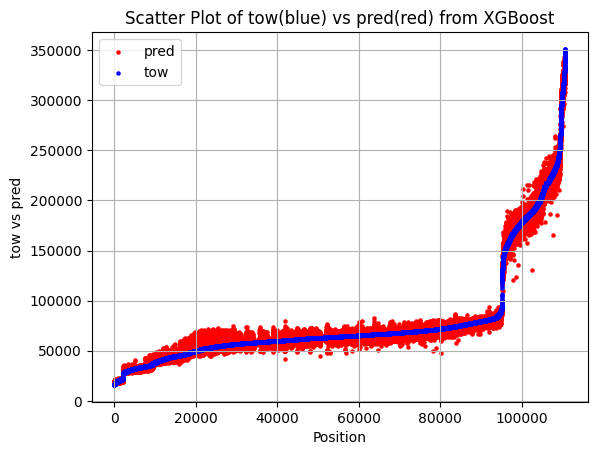

In [37]:
# Create scatter plot for tow and pred
plt.scatter(X_test_sorted['Position'], X_test_sorted['pred'], label='pred', color='red', s=5)
plt.scatter(X_test_sorted['Position'], X_test_sorted['target'], label='tow', color='blue', s=5)

plt.xlabel('Position')
plt.ylabel('tow vs pred')
plt.title('Scatter Plot of tow(blue) vs pred(red) from XGBoost')
plt.legend()
plt.grid()
plt.show()

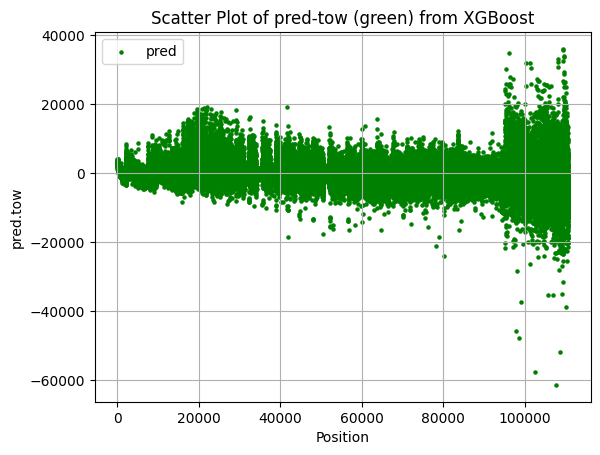

In [38]:
# Create scatter plot for pred-tow
plt.scatter(X_test_sorted['Position'], X_test_sorted['pred']-X_test_sorted['target'], label='pred', color='green', s=5)

plt.xlabel('Position')
plt.ylabel('pred.tow')
plt.title('Scatter Plot of pred-tow (green) from XGBoost')
plt.grid()
plt.legend()
plt.show()

C:\Temp\ipykernel_1928\3551165520.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_c['pred_err'] = df_pred_c['pred']-df_pred_c['tow']
C:\Temp\ipykernel_1928\3551165520.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_c['aircraft_type'] = pd.Categorical(df_pred_c['aircraft_type'],


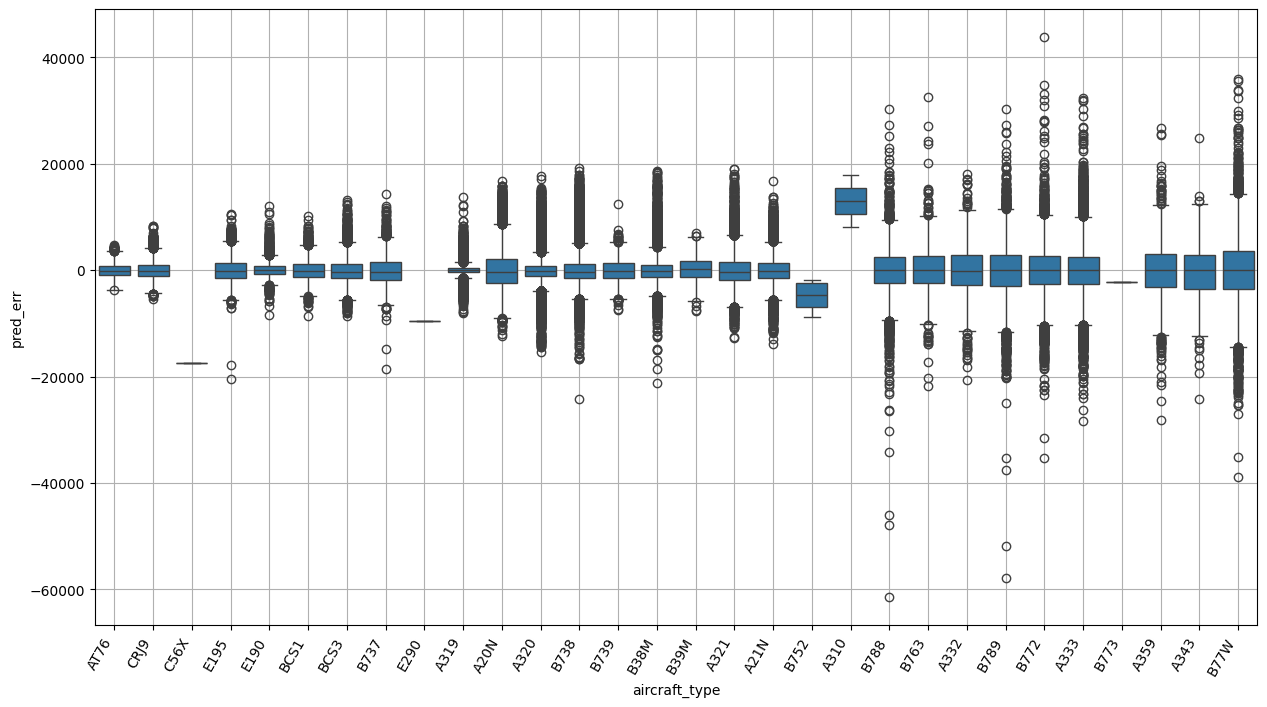

In [39]:
df_pred_c = df_pred[(df_pred['cset'] == True)]

df_pred_c['pred_err'] = df_pred_c['pred']-df_pred_c['tow']

# Compute the median for each category
category_median = df_pred_c.groupby('aircraft_type', observed=False)['pred'].median().reset_index()

# Sort the categories by the median
category_median_sorted = category_median.sort_values(by='pred')

# Reorder the categories in the DataFrame based on the sorted median
df_pred_c['aircraft_type'] = pd.Categorical(df_pred_c['aircraft_type'],
                                categories=category_median_sorted['aircraft_type'],
                                ordered=True)

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=df_pred_c, x='aircraft_type', y='pred_err')
plt.grid()
plt.xticks(rotation=60, ha='right')
plt.show()

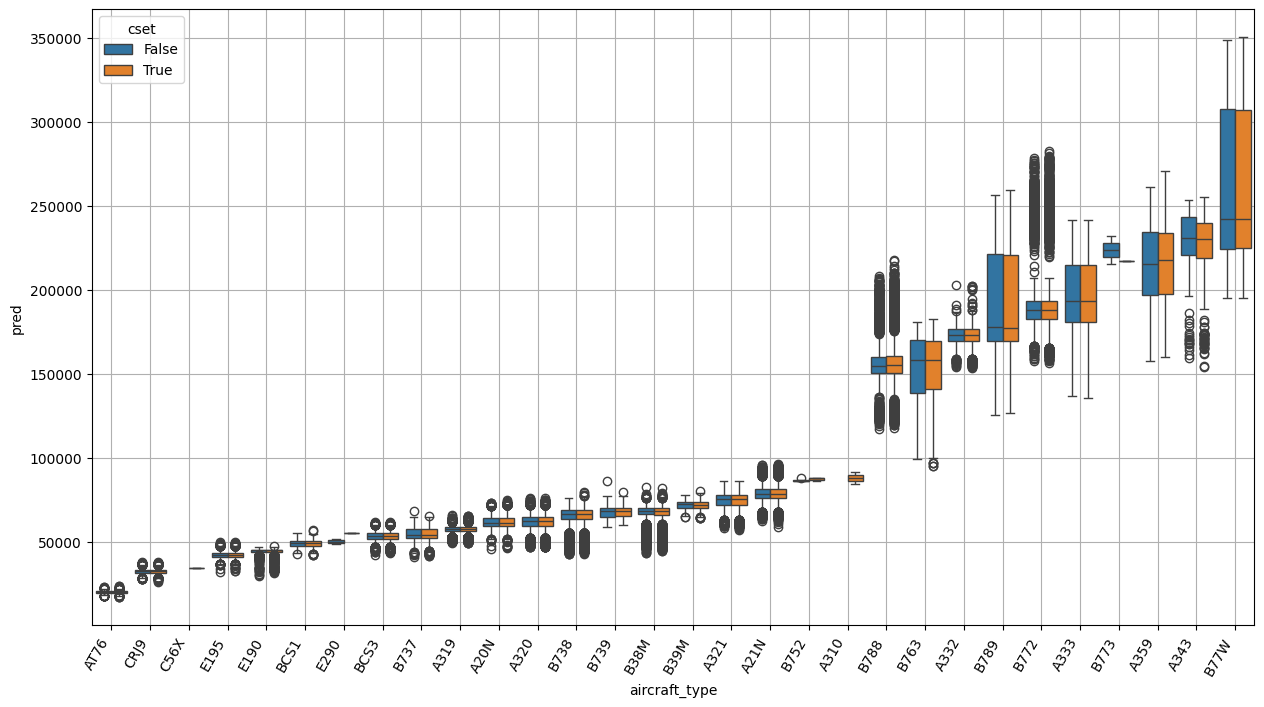

In [40]:
# Compute the median for each category
category_median = df_pred.groupby('aircraft_type')['pred'].median().reset_index()

# Sort the categories by the median
category_median_sorted = category_median.sort_values(by='pred')

# Reorder the categories in the DataFrame based on the sorted median
df_pred['aircraft_type'] = pd.Categorical(df_pred['aircraft_type'],
                                categories=category_median_sorted['aircraft_type'],
                                ordered=True)

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=df_pred, x='aircraft_type', y='pred', hue='cset')
plt.grid()
plt.xticks(rotation=60, ha='right')
plt.show()

# Refined model on flights with reasonable RoC feature

In [41]:
# Start from initial prediction model
df_pred

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,year,month,week,weekday,hour,weekday_name,WJFUELUSGULF,route,flown_distance_med,pred
0,248763780,2022-01-01,3840d84f25d3f5fcc0a1be3076bb4039,EGLL,London Heathrow,GB,EICK,Cork,IE,2022-01-01T13:46:00Z,...,2022,1,52,5,0,Saturday,3.322,EGLL EICK,322.0,55021.000000
1,248760618,2022-01-01,f6f610e73002b8892a239a81321f7f1d,LEBL,Barcelona,ES,KMIA,Miami,US,2022-01-01T09:55:00Z,...,2022,1,52,5,0,Saturday,3.322,LEBL KMIA,4200.0,187039.312500
2,248753824,2022-01-01,139670936660762c230ca92556ba842b,ESSA,Stockholm Arlanda,SE,KORD,Chicago O'Hare,US,2022-01-01T09:39:00Z,...,2022,1,52,5,0,Saturday,3.322,ESSA KORD,3763.0,218622.234375
3,248753852,2022-01-01,509dc61bb54fbab0e5406067c95603e2,LSZH,Zurich,CH,KPHL,Philadelphia,US,2022-01-01T11:04:00Z,...,2022,1,52,5,0,Saturday,3.322,LSZH KPHL,3617.5,162391.218750
4,248755934,2022-01-01,d0610d000dcf26b1d7bba8103ecc393d,EIDW,Dublin,IE,EGLL,London Heathrow,GB,2022-01-01T12:36:00Z,...,2022,1,52,5,0,Saturday,3.322,EIDW EGLL,292.0,68996.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527157,258068876,2022-12-31,c9fca302ca2e28acab0eb0bb1b46f11b,LTFM,iGA Istanbul,TR,LSZH,Zurich,CH,2022-12-31T09:25:00Z,...,2022,12,52,5,0,Saturday,3.322,LTFM LSZH,984.0,76000.656250
527158,258064675,2022-12-31,00f96ad0e382476649574ba044c764fc,EHAM,Amsterdam,NL,EDDF,Frankfurt,DE,2022-12-31T10:04:21Z,...,2022,12,52,5,0,Saturday,3.322,EHAM EDDF,233.0,60342.906250
527159,258065436,2022-12-31,87c552b7f6d9bbd16a66e95df761c7f2,LEBL,Barcelona,ES,KJFK,New York JFK,US,2022-12-31T09:34:00Z,...,2022,12,52,5,0,Saturday,3.322,LEBL KJFK,3389.0,194567.375000
527160,258058138,2022-12-31,2cd57e434494606c965bac87c024bda2,LIPE,Bologna,IT,LOWW,Vienna,AT,2022-12-31T09:37:00Z,...,2022,12,52,5,0,Saturday,3.322,LIPE LOWW,338.0,40390.207031


## FIXME: RoC specific data cleaning

In [42]:
df_pred.shape

(527162, 85)

In [43]:
df_sel = df_pred                                      # 527162                     => 443076 # 2435, 1730
#df_sel = df_sel.dropna(subset = ['ROC_FL50to100'])    # 527162 => 388612           => 386343 # 2490, 1762
df_sel = df_sel.dropna(subset = ['ROC_FL100to200'])   # 527162 => 444903           => 442432
#df_sel = df_sel.dropna(subset = ['ROC_FL50to100'])   #           444903 => 387492 => 385835

df_sel.shape

(444903, 85)

In [44]:
# keep only row with reasonable 20000ft being found
df_sel = df_sel[df_sel["CL_FL200_alt"]<23000] 
# keep only row with reasonable 10000ft being found
df_sel = df_sel[df_sel["CL_FL100_alt"]<13000]
# keep only row with reasonable 5000ft being found
#df_sel = df_sel[df_sel["CL_FL50_alt"]<7000]
# keep only rows where RoC is lower than 5000ft/min, i.e. climbing 10000ft in more than 2min
df_sel = df_sel[(pd.to_datetime(df_sel["CL_FL200_start"])-pd.to_datetime(df_sel["CL_FL100_start"])).array.total_seconds()/60>2]

# df_sel = df_sel[df_sel["ROC_FL100to200"]<4000]
#df_sel = df_sel[df_sel["ROC_FL100to200"]>1000]

df_sel.shape

(442432, 85)

C:\Temp\ipykernel_1928\962774973.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sel[df_sel['wtc']== 'H'][["aircraft_type", "ROC_FL100to200"]].plot.box(by='aircraft_type')


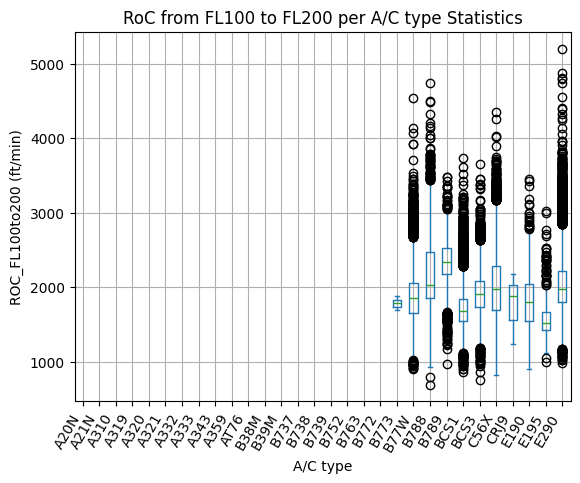

In [45]:
df_sel[df_sel['wtc']== 'H'][["aircraft_type", "ROC_FL100to200"]].plot.box(by='aircraft_type')

plt.title("RoC from FL100 to FL200 per A/C type Statistics")
plt.xlabel("A/C type")
plt.ylabel("ROC_FL100to200 (ft/min)")
plt.grid()
plt.xticks(rotation=60, ha='right')

plt.show()

C:\Temp\ipykernel_1928\484104615.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sel[df_sel['wtc']== 'M'][["aircraft_type", "ROC_FL100to200"]].plot.box(by='aircraft_type')


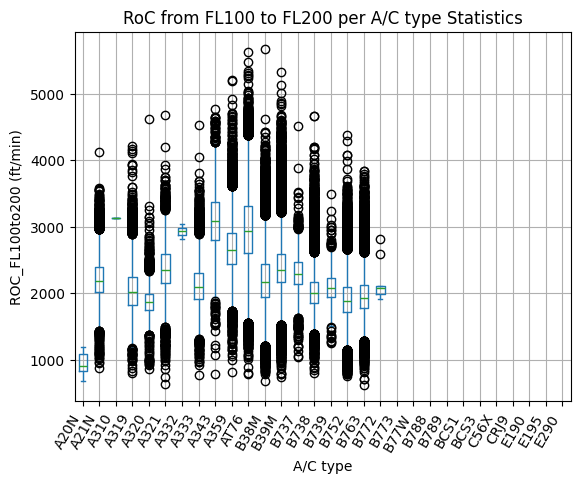

In [46]:
df_sel[df_sel['wtc']== 'M'][["aircraft_type", "ROC_FL100to200"]].plot.box(by='aircraft_type')

plt.title("RoC from FL100 to FL200 per A/C type Statistics")
plt.xlabel("A/C type")
plt.ylabel("ROC_FL100to200 (ft/min)")
plt.grid()
plt.xticks(rotation=60, ha='right')

plt.show()

## Additional feature computation

In [47]:
# Duration of initial climb from take-off to FL100
df_sel['init_cl_dur'] = (pd.to_datetime(df_sel["CL_FL100_start"]) - pd.to_datetime(df_sel["actual_offblock_time"])).array.total_seconds()/60 - df_sel["taxiout_time"]
df_sel['init_cl_durFL50'] = (pd.to_datetime(df_sel["CL_FL50_start"]) - pd.to_datetime(df_sel["actual_offblock_time"])).array.total_seconds()/60 - df_sel["taxiout_time"]
df_sel['to_de_durFL300'] = (pd.to_datetime(df_sel["DE_FL300_start"]) - pd.to_datetime(df_sel["actual_offblock_time"])).array.total_seconds()/60 - df_sel["taxiout_time"]

# Normalized prediction
df_sel['pred2MTOW'] =  df_sel['pred'] / df_sel['MTOW']

## Set features and target

In [48]:
# Baseline features
#features = ['flight_duration', 'taxiout_time', 'flown_distance', 'year', 'month', 'weekday', 'hour'] + dummy_columns_only #
# features = ['flown_distance', 'year', 'month', 'weekday', 'hour'] + dummy_columns_only #
#features = ['taxiout_time', 'flown_distance_avg', 'year', 'month', 'weekday', 'hour'] + dummy_columns_only #
features = ['taxiout_time'] # should actauly not impact ATOW when considering the actual climbs, but removing degrades the model
#features = []

# Normalized inital prediction
features = features + ['pred2MTOW']
#features = features + ['pred'] # degrading

# Additional features
features = features + ['ROC_FL100to200']
# features = features + ['TAS_FL100to200']                    # Removed RMSE= 2392, 1505
features = features + ['Temp_FL100to200']
#features = features + ['TASp2__FL100to200']
#features = features + ['ROC2TAS']
features = features + ['init_cl_dur']
features = features + ['MTOW', 'MLW']
features = features + ['ac_L', 'ac_B']                        # RMSE= 2678, 2371 => v2 RMSE = 3033.92
features = features + ['Q_mFL100to200']                       # RMSE= 2538, 2085
features = features + ['Q_FL100', 'Q_FL200']                  # RMSE= 2493, 1968
features = features + ['TAS_FL100', 'dHp_FL100']              # RMSE= 2486, 2051
features = features + ['TAS_FL200', 'dHp_FL200']              # RMSE= 2477, 1948 => v3 RMSE = ???, as submitted with bug
features = features + ['TAS_mFL100to200', 'dHp_mFL100to200']  # RMSE= 2469, 1851 => v4 RMSE = 2850.31
#features = features + ['cs_d_track']                          # RMSE= 2475, 1786 => overfitting? right feature?
features = features + ['Q_mFL50to100']                        # RMSE=
features = features + ['Q_FL50']                              # RMSE=
features = features + ['TAS_FL50', 'dHp_FL50']                # RMSE=
features = features + ['TAS_mFL50to100', 'dHp_mFL50to100']    # RMSE= 2440, 1722 on 309677, i.e. exluding 
                                                              # RMSE= 2425, 1795 => v5 RMSE = 2806.87
#features = features + ['cs_d_track', 'cs_d_track_50to100']    # RMSE= 2417, 1575 => only minor improvement, but more overfitting?
features = features + ['init_cl_durFL50']
#features = features + ['cs_d_track', 'cs_d_track_50to100']    # RMSE= 2396, 1579 => only minor improvement, but more overfitting?
                                                              #                 => v6 RMSE = 2798.52
                                                              # before final fix: 2385, 1517 => 2401, 1580
features = features + ['Temp_FL50to100']                      # RMSE= 2388, 1587
# features = features + ['ROC_FL50to100']                       # RMSE= 2396, 1688
# features = features + ['TAS_FL50to100']                       # RMSE= 2396, 1564 => degradation & more overfitting 

#features = features + ['avg_ROD']                             # 2385, 1517

# v6 RMSE= 3390, 2775; 2396, 1579 ==> 2798.52
# v7 RMSE= 3378, 2727; 2369, 1485 ==> 2799.09 # added fp and used fixed d_track
# v8 RMSE= 3378, 2727; 2365, 1645 ==> 2802.15 # removed d_track again, showing slight improvement on test, but less overfitting on train 
# v9 RMSE= 3382, 2765; 2390, 1703 ==> 2802.81 # failed attempt to limit overfitting

#features = features + ['ROD_FL300to200']                      # 2391, 1647
features = features + ['Q_mFL300to200']                        # 2395, 1765
features = features + ['to_de_durFL300']                       # 2347, 1912 v10: 2752.72
features = features + ['ROD_FL300to200', 'TAS_mFL300to200']

target = 'tow'

## Split data again into challenge and submisson sets

In [49]:
df_sel_c = df_sel[df_sel['cset'] == True]
df_sel_c.shape

(309677, 89)

In [50]:
df_sel_s = df_sel[df_sel['cset'] == False]
df_sel_s.shape

(132755, 89)

## Split data into sets for training and testing

In [51]:
Y = df_sel_c[target]
X = df_sel_c[features]
X2_train, X2_test, y2_train, y2_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(len(X2_train), len(X2_test))

216773 92904


### Features for submission set

In [52]:
X2_sub = df_sel_s[features]

## Train XGBoost tree

In [ ]:
if bTrainModel:
    #xg_model = XGBRegressor(n_estimators=1000, learning_rate=0.2, random_state=42)

    xg_model = XGBRegressor(
                        n_estimators=7000,            
                      #  learning_rate=0.05,
                        learning_rate=0.02,
                        max_depth=7,
                        subsample=0.8,                
                        colsample_bytree=0.8,        
                        reg_alpha=0.5,  
                        reg_lambda=2, 
                        min_child_weight=5,
                        gamma=0.07,
                        early_stopping_rounds=50,
                        eval_metric='rmse',
    )
    
    # Train the model on the training data
    xg_model.fit(
        X2_train, 
        y2_train, 
        eval_set=[(X2_test, y2_test)],
        # verbose=True
    )

else:
    # Load the model saved with save_model()
    xg_model = XGBRegressor()
    xg_model.load_model("refined_xgb_model.json")

[0]	validation_0-rmse:52346.03142
[1]	validation_0-rmse:51307.18031
[2]	validation_0-rmse:50289.69345
[3]	validation_0-rmse:49291.82685
[4]	validation_0-rmse:48314.06411
[5]	validation_0-rmse:47370.99499
[6]	validation_0-rmse:46431.88903
[7]	validation_0-rmse:45511.11137
[8]	validation_0-rmse:44625.35022
[9]	validation_0-rmse:43740.73971
[10]	validation_0-rmse:42896.94073
[11]	validation_0-rmse:42047.62544
[12]	validation_0-rmse:41215.69122
[13]	validation_0-rmse:40414.74845
[14]	validation_0-rmse:39633.71500
[15]	validation_0-rmse:38850.02482
[16]	validation_0-rmse:38081.62589
[17]	validation_0-rmse:37343.82468
[18]	validation_0-rmse:36605.76039
[19]	validation_0-rmse:35882.30476
[20]	validation_0-rmse:35173.27444
[21]	validation_0-rmse:34478.45046
[22]	validation_0-rmse:33811.49688
[23]	validation_0-rmse:33144.00891
[24]	validation_0-rmse:32504.63828
[25]	validation_0-rmse:31881.31780
[26]	validation_0-rmse:31267.03978
[27]	validation_0-rmse:30665.94116
[28]	validation_0-rmse:30061.7

### Predictions

In [ ]:
# Make predictions on the test data
y2_pred = xg_model.predict(X2_test)
mse = mean_squared_error(y2_test, y2_pred)
rmse = np.sqrt(mse)
print('XGBoost tree on test data:')
print(f"Mean Squared Error (MSE) is: {mse:.0f} \nRoot Mean Squared Error (RMSE) is: {rmse:.0f}")

In [ ]:
# Make predictions on the training data
y2_pred_train = xg_model.predict(X2_train)
mse = mean_squared_error(y2_train, y2_pred_train)
rmse = np.sqrt(mse)
print('XGBoost tree on training data:')
print(f"Mean Squared Error (MSE) is: {mse:.0f} \nRoot Mean Squared Error (RMSE) is: {rmse:.0f}")

In [ ]:
# Make prediction on the submission set data
y2_pred_sub = xg_model.predict(X2_sub)

### Save model

In [ ]:
if bSaveModel and bTrainModel:
    # Save model for later re-use
    xg_model.save_model('refined_xgb_model.json')
    
    # Dump model with feature map
    # xg_model.dump_model('refined_xgb_model_raw.json') ## seems not to work

## Plot predictions

In [ ]:
X2_test['target'] = y2_test
X2_test['pred'] = y2_pred
X2_train['target'] = y2_train
X2_train['pred'] = y2_pred_train
X2_sub['pred'] = y2_pred_sub

In [ ]:
X2_test_sorted = X2_test.sort_values(by='target').reset_index(drop=True)
X2_test_sorted['Position'] = range(1, len(X2_test_sorted) + 1)

In [ ]:
# Create scatter plot for tow and pred
plt.scatter(X2_test_sorted['Position'], X2_test_sorted['pred'], label='pred', color='red', s=5)
plt.scatter(X2_test_sorted['Position'], X2_test_sorted['target'], label='tow', color='blue', s=5)

plt.xlabel('Position')
plt.ylabel('tow vs pred')
plt.title('Scatter Plot of tow(blue) vs pred(red) from XGBoost')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Create scatter plot for tow and pred
plt.scatter(X2_test_sorted['Position'], X2_test_sorted['pred']/X2_test_sorted['MTOW'], label='pred', color='red', s=5)
plt.scatter(X2_test_sorted['Position'], X2_test_sorted['target']/X2_test_sorted['MTOW'], label='tow', color='blue', s=5)

plt.xlabel('Position')
plt.ylabel('tow/MTOW vs pred/MTOW')
plt.title('Scatter Plot of tow(blue) vs pred(red) from XGBoost')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Create scatter plot for pred-tow
plt.scatter(X2_test_sorted['Position'], X2_test_sorted['pred']-X2_test_sorted['target'], label='pred', color='green', s=5)

plt.xlabel('Position')
plt.ylabel('pred-tow')
plt.title('Scatter Plot of pred-tow (green) from XGBoost')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Add predictions for all sets to dataframe
df_pred2 = df.join(X2_test[['pred']])
df_pred2.update(X2_train[['pred']])
df_pred2.update(X2_sub[['pred']])
df_pred2

In [ ]:
df_pred2_c = df_pred2[(df_pred['cset'] == True)]

df_pred2_c['pred_err'] = df_pred2_c['pred']-df_pred2_c['tow']

# Compute the median for each category
category_median = df_pred2_c.groupby('aircraft_type', observed=False)['pred'].median().reset_index()

# Sort the categories by the median
category_median_sorted = category_median.sort_values(by='pred')

# Reorder the categories in the DataFrame based on the sorted median
df_pred2_c['aircraft_type'] = pd.Categorical(df_pred2_c['aircraft_type'],
                                categories=category_median_sorted['aircraft_type'],
                                ordered=True)

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=df_pred2_c, x='aircraft_type', y='pred_err')
plt.grid()
plt.xticks(rotation=60, ha='right')
plt.show()

In [ ]:
# Compute the median for each category
category_median = df_pred2.groupby('aircraft_type')['pred'].median().reset_index()

# Sort the categories by the median
category_median_sorted = category_median.sort_values(by='pred')

# Reorder the categories in the DataFrame based on the sorted median
df_pred2['aircraft_type'] = pd.Categorical(df_pred2['aircraft_type'],
                                categories=category_median_sorted['aircraft_type'],
                                ordered=True)

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=df_pred2, x='aircraft_type', y='pred', hue='cset')
plt.grid()
plt.xticks(rotation=60, ha='right')
plt.show()

# Merge refined model predictions and global model predictions

## Compute individual model RMSEs

In [ ]:
# RMSE for global model (test + train set)
df_pred_c = df_pred[(df_pred['cset'] == True)]
mse = mean_squared_error(df_pred_c[['tow']], df_pred_c[['pred']])
rmse = np.sqrt(mse)
lines = len(df_pred_c)
print(f"XGBoost tree on test+train data ({lines:} lines):")
print(f"Mean Squared Error (MSE) is: {mse:.0f} \nRoot Mean Squared Error (RMSE) is: {rmse:.0f}")

In [ ]:
# RMSE for refined model (test + train set)
df_pred2_c = df_pred2[(df_pred2['cset'] == True) & (pd.notnull(df_pred2['pred']))]
mse = mean_squared_error(df_pred2_c[['tow']], df_pred2_c[['pred']])
rmse = np.sqrt(mse)
lines = len(df_pred2_c)
print(f"XGBoost tree on test+train data ({lines:} lines):")
print(f"Mean Squared Error (MSE) is: {mse:.0f} \nRoot Mean Squared Error (RMSE) is: {rmse:.0f}")

## Compile and check merged model

In [ ]:
# Update preditions of "global" model with predictions of "refined" model
df_pred_final = df_pred
df_pred_final = df_pred_final.set_index('flight_id')

df_pred2_idx = df_pred2
df_pred2_idx = df_pred2_idx.set_index('flight_id')

df_pred_final.update(df_pred2_idx['pred'])
df_pred_final.reset_index(inplace=True)

In [ ]:
# RMSE for "merged" model (="global" with "refined") on (test + train set)
df_pred_final_c = df_pred_final[(df_pred_final['cset'] == True)]
mse = mean_squared_error(df_pred_final_c[['tow']], df_pred_final_c[['pred']])
rmse = np.sqrt(mse)
lines = len(df_pred_final_c)
print(f"XGBoost tree on test+train data ({lines:} lines):")
print(f"Mean Squared Error (MSE) is: {mse:.0f} \nRoot Mean Squared Error (RMSE) is: {rmse:.0f}")

## Plot predictions

In [ ]:
X_test_sorted = df_pred_final_c.sort_values(by='tow').reset_index(drop=True)
X_test_sorted['Position'] = range(1, len(X_test_sorted) + 1)

In [ ]:
# Create scatter plot for tow and pred
plt.scatter(X_test_sorted['Position'], X_test_sorted['pred'], label='pred', color='red', s=5)
plt.scatter(X_test_sorted['Position'], X_test_sorted['tow'], label='tow', color='blue', s=5)

plt.xlabel('Position')
plt.ylabel('tow vs pred')
plt.title('Scatter Plot of tow(blue) vs pred(red) from XGBoost')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Compute the median for each category
category_median = df_pred_final.groupby('aircraft_type')['pred'].median().reset_index()

# Sort the categories by the median
category_median_sorted = category_median.sort_values(by='pred')

# Reorder the categories in the DataFrame based on the sorted median
df_pred_final['aircraft_type'] = pd.Categorical(df_pred_final['aircraft_type'],
                                categories=category_median_sorted['aircraft_type'],
                                ordered=True)

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=df_pred_final, x='aircraft_type', y='pred', hue='cset')
plt.grid()
plt.xticks(rotation=60, ha='right')
plt.show()

# Write prediction on submission set

## Prepare submission set contents

In [ ]:
df_out = df_pred_final[df_pred_final['cset'] == False][['flight_id', 'pred']]
df_out = df_out.rename(columns={"pred": "tow"})
df_out

## Get team info

In [ ]:
import json

In [ ]:
with open('response_XXXXXXXXXXXXX.json') as f:
   team = json.load(f)
team

## Define and write submission set file

In [ ]:
# <team_name>_v<num>_<team_id>.csv
num = 10 # version number
strOutFile = (team['team_name'] + '_v' + str(num) + '_' + team['team_id'] + '.csv')

if not os.path.isfile(strOutFile):
    df_out.to_csv(strOutFile, index=False)
    print('Submission set file <' + strOutFile + '> saved!')
else:
    print('Submission set file <' + strOutFile + '> already exists! \nDelete file manualy to replace it!')

# Post-processing

In [ ]:
df_pred2_c['pred_err'] = df_pred2_c['pred']-df_pred2_c['tow']
B77W = df_pred2_c.groupby("aircraft_type").get_group("B77W")
B77W

In [ ]:
pd.options.mode.copy_on_write = True 
B77W["route"] = B77W[["adep", "ades"]].agg(" ".join, axis=1)
route_cnt = B77W.groupby("route").size().reset_index(name='count').sort_values(by = "count", ascending=False)
route_cnt.head(6)

In [ ]:
# Reorder the categories in the DataFrame based on the sorted median
B77W['route'] = pd.Categorical(B77W['route'],
                                categories=route_cnt['route'],
                                ordered=True)

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=B77W, x='route', y='pred_err')
plt.grid()
plt.xticks(rotation=60, ha='right')
plt.show()

In [ ]:
selroute = route_cnt["route"].iloc[0]
selroute

In [ ]:
B77Wroute = B77W.groupby("route").get_group(selroute).sort_values(by = "pred_err")
B77Wroute[['tow', 'pred', 'pred_err', 'ROC_FL100to200', 'flown_distance', 'flight_duration']]

In [ ]:
B77Wroute.columns


In [ ]:
sns.pairplot(data=B77Wroute, hue="pred_err", palette="Spectral", vars = ['taxiout_time','flight_duration','flown_distance','tow', 'ROC_FL100to200', 'TAS_FL100to200'])


In [ ]:
B77Wroute['ROC2TAS'] = B77Wroute['ROC_FL100to200'] / B77Wroute['TAS_FL100to200']

In [ ]:
sns.pairplot(data=B77Wroute, hue="pred_err", palette="Spectral", vars = ['tow', 'ROC_FL100to200', 'TAS_FL100to200','ROC2TAS'])

In [ ]:
sns.pairplot(data=B77Wroute, hue="pred_err", palette="Spectral", vars = ['pred_err','tow', 'ROC_FL100to200', 'TAS_FL100to200', 'Temp_FL100to200'])

In [ ]:
#B77Wroute.groupby(['route'])['flown_distance'].mean().reset_index()
tmp= B77W['flown_distance'].groupby( B77W['route']).transform('mean')
tmp

In [ ]:
B77W

In [ ]:
df.columns


In [ ]:
df_pred_c['pred_err'] = df_pred2_c['pred']-df_pred_c['tow']
df_pred_c['pred_err_abs'] = abs(df_pred2_c['pred']-df_pred_c['tow'])
tmp = df_pred_c.groupby("aircraft_type").get_group("A320")
tmp[['tow', 'pred','pred_err']]

In [ ]:
df_pred_c[df_pred_c['pred_err_abs'] <200]

In [ ]:
df_sel = df_sel[df_sel["init_cl_dur"]<30]
hist = df_sel['init_cl_dur'].hist(bins=40)

In [ ]:
df_sel['cl_dur'] = (pd.to_datetime(df_sel["CL_FL200_start"])-pd.to_datetime(df_sel["CL_FL100_start"])).array.total_seconds()/60

In [ ]:
df_sel = df_sel[df_sel["cl_dur"]<30]
hist = df_sel['cl_dur'].hist(bins=40)

In [ ]:
df['tow_int'] = abs(df['tow'].round() - df['tow'])<0.0001

In [ ]:
df['tow_int']

In [ ]:
tmp = df[df['tow_int'] == True]
tmp

In [ ]:
tmp['taxiout_time']

In [ ]:
df_pred2['pred2MTOW'] = df_pred2['pred']/df_pred2['MTOW']
df_pred2['pred_err'] = df_pred2['pred']-df_pred['tow']

In [ ]:
df_pred2[['aircraft_type','tow','pred_err', 'MTOW']][df_pred2['pred2MTOW']<0.55]



In [ ]:
df_pred2_s = df_pred2[(df_pred['cset'] == False)]

In [ ]:
df_pred2_s[['aircraft_type','pred','pred2MTOW', 'MTOW']][df_pred2_s['pred2MTOW']>1]